In [5]:
# Implementation of the "Decentralized Delayed Upper Confidence Bound" (DDUCB)
# algorithm as presented in "Decentralized Cooperative Stochastic Bandits" by
# Martinez-Rubio et al. (Neurips 2019)
#
# Arxiv full text available at: https://arxiv.org/pdf/1810.04468.pdf
#

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy as scp
import time

In [7]:
class Gaussian_Bandit:
    
    # Accept a list of K >= 2 floats, representing means of
    # Gaussian distributions for each bandit arm
    def __init__(self,means):
        self.bandit_means = means
        self.rand_regret = 0
        self.pseudo_rand_regret = 0
        self.best_mean = max(self.bandit_means)
    
    # Function that returns the number of bandit arms
    def K(self):
        return len(self.bandit_means)
    
    # Accepts a parameter 0 <= a <= K-1 and returns the
    # realization of random variable X with P(X=1) being the
    # mean of the (a+1)^th arm.
    def pull(self,a):
        selected_arm_mean = self.bandit_means[a]
        selected_arm_sample = norm.rvs(loc=selected_arm_mean,size=1)
        self.rand_regret = self.rand_regret + (self.best_mean - selected_arm_sample)
        self.pseudo_rand_regret = self.pseudo_rand_regret + (self.best_mean - selected_arm_mean)
        return selected_arm_sample
    
    # Returns the regret incurred so far.
    def random_regret(self):
        return self.rand_regret
    
    def pseudo_random_regret(self):
        return self.pseudo_rand_regret

In [8]:
def construct_cycle_graph(N):
    """
    N: number of states in the cycle graph
    
    G: Cycle graph adjacency matrix
    """
    G = np.zeros((N,N))
    for i in range(N):
        if i == 0:
            G[i,i+1] = 1
            G[i,N-1] = 1
        elif i == N-1:
            G[i,0] = 1
            G[i,i-1] = 1  
        else:
            G[i,i+1] = 1
            G[i,i-1] = 1
    return G

In [9]:
def construct_cycle_com_mat(G):
    """
    G: Adjacency matrix of cycle graph G
    
    P: Mixing matrix
    lam_2: Second largest eigenvalue of P
    
    NOTE: This is a general procedure to construct a matrix P
        for a regular graph such that 1'*P = 1' and P*1 = 1.
    
    """
    N = np.shape(G)[0]
    
    # Construct P
    D = 2*np.identity(N)
    D_neg_half = np.linalg.inv(scp.linalg.sqrtm(D))
    L = np.identity(N) - D_neg_half @ G @ D_neg_half
    P = np.identity(N) - (2/(2+1))*L
    
    # Second largest eigenvalue of P
    eigs = np.linalg.eigvals(P)
    eigs_sorted = np.sort(np.absolute(eigs))
    lam_2 = eigs_sorted[-2]
    
    return P, lam_2

In [35]:
def mix(N,r,y_r,y_rm1,P,w_rm1,w_r,w_rp1,K,lam_2):
    """
    Accelerated communication and mixing step
    
    N : number of agents
    r : current time step in the sub-interval
    y_r : parameter to be mixed, for all agents
    y_rm1 : parameter to be mixed, previous time step (for all agents)
    P : communication weighting matrix
    w_rm1 : previous weight
    w_r : current weight
    w_rp1 : new weight
    K : number of arms in the bandit
    """
    
    # Perform the mixing process
    y_rp1 = np.zeros((N,K))
    y_prime = np.zeros((N,K))
    for ag in range(N):
        for arm in range(K):
            y_prime[ag,arm] = (2/np.absolute(lam_2))*(np.dot(P[ag,:],y_r[:,arm]))
            y_rp1[ag,arm] = (w_r/w_rp1)*y_prime[ag,arm] - (w_rm1/w_rp1)*y_rm1[ag,arm]
            
    return y_rp1

In [36]:
def DDUCB(C,N,eta,P,lam_2,T,bandit):
    """
    C: parameter determining how long to mix values
    N: number of agents (i.e. vertices) in the graph
    eta: exploration parameter
    P: communication graph
    lam_2: second largest eigenvalue (in absolute value) of P
    T: total time horizon
    bandit: multi-arm bandit to sample from
    
    NOTE: I have assumed that sigma (variance of each arm) is 1!
        Check the paper for where to plug this value in if necessary.
    
    """
    
    # Bandit regret
    cum_band_regret_over_time = np.zeros((T,1))
    
    # For the initial step, we first spend K time steps sampling each
    # arm for each agent.
    xi = np.zeros((N,bandit.K()))
    z = np.zeros((N,bandit.K()))
    
    # Each agent samples each arm once to begin the algorithm
    for arm in range(bandit.K()):
        for ag in range(N):
            samp = bandit.pull(arm)
            xi[ag,arm] += samp
            z[ag,arm] += 1
        cum_band_regret_over_time[arm] = bandit.random_regret()
    
    # "\alpha" contains information about mixed rewards, with "a"
    # the number of respective arms pulls for the mixed samples.
    alpha = xi/N
    a = z/N
    
    # "\beta" contains information about rewards being mixed, with "b"
    # the number of respective arm pulls for the mixing samples
    beta = xi[:,:]
    b = z[:,:]
    
    # "gamma" contains information about rewards obtained at the current
    # stage, with "c" the number of respective arm pulls for the currently
    # sampled arms (Question: Is this always not just a vector with a single "1"?)
    gamma = np.zeros((N,bandit.K()))
    c = np.zeros((N,bandit.K()))
    
    # Placeholder values for the end of a time interval
    delta = np.zeros((N,bandit.K()))
    d = np.zeros((N,bandit.K()))
    
    # Now, run the general portion of the DDUCB algorithm
    t = bandit.K()
    s = bandit.K()
    while t <= T-1:
        
        # Determine the current optimal action for each agent
        # using an upper confidence bound
        k_star = np.zeros((N,))
        for ag in range(N):
            ucb_cur_ag = np.zeros((bandit.K(),))
            for arm in range(bandit.K()):
                ucb_cur_ag[arm] = alpha[ag,arm]/a[ag,arm] + np.sqrt((2*eta*np.log(s))/(N*a[ag,arm]))
            k_star[ag] = np.argmax(ucb_cur_ag)
        k_star = k_star.astype(int)
        
        # Before each sub-interval, reset the mix weights
        w_rm1 = 0
        w_r = 1/2
        w_rp1 = 2*w_r/abs(lam_2) - w_rm1
        
        # Before each sub-interval, reset the mixes
        beta_rm1 = np.zeros((N,bandit.K()))
        beta_r = beta[:]/2
        beta_rp1 = None
        b_rm1 = np.zeros((N,bandit.K()))
        b_r = b[:]/2
        b_rp1 = None 
        
        # Iterate through a mixing period
        for r in range(C-1):
            
            # Iterate through each agent, pull currently optimal arm
            for ag in range(N):
                samp = bandit.pull(k_star[ag])
                gamma[ag,k_star[ag]] += samp
                c[ag,k_star[ag]] += 1
                
            # Mix the information
            beta_rp1 = mix(N,r,beta_r,beta_rm1,P,w_rm1,w_r,w_rp1,bandit.K(),lam_2)
            b_rp1 = mix(N,r,b_r,b_rm1,P,w_rm1,w_r,w_rp1,bandit.K(),lam_2)
            
            # Update condition from Algorithm
            if r == 0:
                w_r = 2*w_r
                beta_r = 2*beta_r
                b_r = 2*b_r
            
            # Add the regret to the vector
            cum_band_regret_over_time[t] = bandit.random_regret()
            
            # Iterate the counter
            t = t+1
            
            # Update the weights for the next step in the sub-interval
            w_rm1 = w_r
            w_r = w_rp1
            w_rp1 = 2*w_rp1/np.absolute(lam_2) - w_r
            
            # Update the values of y for the next step in the interval
            beta_rm1 = beta_r[:]
            beta_r = beta_rp1[:]
            beta_rp1 = None
            b_rm1 = b_r[:]
            b_r = b_rp1[:]
            b_rp1 = None
            
            if t % 1000 == 0:
                print(t)
            
            # Break the loop if we hit the time horizon, T
            if t >= T:
                break
        
        # Update mixing
        s = (t-C)*N
        delta += beta_r
        d += b_r
        alpha = delta[:]
        a = d[:]
        beta = gamma[:]
        b = c[:]
        gamma = np.zeros((N,bandit.K()))
        c = np.zeros((N,bandit.K()))
        
        
    return cum_band_regret_over_time

-------------
Trial number:
0
-----


c:\users\micha\miniconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt


1000
2000
3000
4000
5000
-------------
Trial number:
1
-----
1000
2000
3000
4000
5000
-------------
Trial number:
2
-----
1000
2000
3000
4000
5000
-------------
Trial number:
3
-----
1000
2000
3000
4000
5000
-------------
Trial number:
4
-----
1000
2000
3000
4000
5000
-------------
Trial number:
5
-----
1000
2000
3000
4000
5000
-------------
Trial number:
6
-----
1000
2000
3000
4000
5000
-------------
Trial number:
7
-----
1000
2000
3000
4000
5000
-------------
Trial number:
8
-----
1000
2000
3000
4000
5000
-------------
Trial number:
9
-----
1000
2000
3000
4000
5000


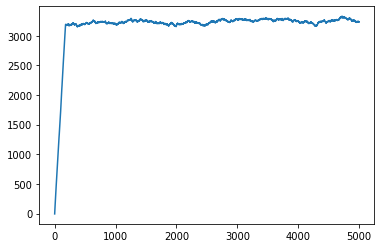

In [37]:
def main():
    
    # Number of trials to average over
    num_trials = 10
    
    # Number of total iterations per trial
    T = 5000
    
    # Assumes one arm with mean 1 and 16 arms with mean 0.8
    K = [1.]
    K.extend([0.8 for i in range(16)])
    
    # Parameters of the problem
    
    # The exploration parameter
    eta = 2.
    
    # Mixing precision after a stage
    epsilon = 1/22
    
    # Assume a cycle graph of size N (N is number of agents)
    N = 100
    G = construct_cycle_graph(N)
    P,lam_2 = construct_cycle_com_mat(G)
    
    # Constant factor C for mixing 
    C = int(np.ceil(np.log(2*N/epsilon)/np.sqrt(2*np.log(1/abs(lam_2)))))
    
    # Run the algorithm and average over trials
    avg_reg_over_time = np.zeros((T,1))
    for i in range(num_trials):
        print('-------------')
        print('Trial number:')
        print(i)
        print('-----')
        bandit = Gaussian_Bandit(K)
        avg_reg_over_time += DDUCB(C,N,eta,P,lam_2,T,bandit)
    
    plt.plot(avg_reg_over_time/num_trials)
    plt.show()
    
if __name__ == "__main__":
    main()